# Comparing regular VGG vs an Adversarially Robust VGG

This is a modification to the accompanying notebook for the blog post https://reiinakano.com/2019/06/21/robust-neural-style-transfer.html

This code is not meant to be run without a GPU.


## Download sample images (if necessary)

In [1]:
# note: we (shats and aharon) only tested this with the starry-night image for style and bigben for
# content below, but you can run with all the others if you like.
# Also these are already in /imgs, so you dont need to run these
# !wget https://storage.googleapis.com/tensorflow-lucid/static/img/notebook-styletransfer-bigben.jpg -P ./imgs
# !wget https://raw.githubusercontent.com/jcjohnson/neural-style/master/examples/inputs/the_scream.jpg -P ./imgs



# Extras:
# !wget https://storage.googleapis.com/tensorflow-lucid/static/img/starry-night.png -P ./imgs
# !wget https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
# !wget https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg
# !wget https://raw.githubusercontent.com/jcjohnson/neural-style/master/examples/inputs/escher_sphere.jpg
# !wget https://raw.githubusercontent.com/jcjohnson/neural-style/master/examples/inputs/woman-with-hat-matisse.jpg
# !wget https://raw.githubusercontent.com/jcjohnson/neural-style/master/examples/inputs/tubingen.jpg
# !wget https://images.academics.com/working-in-tuebingen.jpg

## Imports

In [2]:
import sys
import os
import io
import json
import time
import copy
import glob

from PIL import Image

import matplotlib.pyplot as plt

import torch as ch
import torch.nn.functional as functional
import torch.optim as optim
import torch.utils.model_zoo as model_zoo
import torch.nn as nn

import torchvision.transforms.functional as F
import torchvision.models as models
from torchvision import transforms

from robustness import datasets, model_utils, tools
# from robustnes import constants, helpers <- DEPRECATED

In [3]:
device = ch.device("cuda" if ch.cuda.is_available() else "cpu")

# desired size of the output image
imsize = 512 if ch.cuda.is_available() else 128  # use small size if no gpu


def image_loader(image_name):
  loader = transforms.Compose([
      transforms.Resize(imsize),  # scale imported image
      transforms.ToTensor()])  # transform it into a torch tensor

  image = Image.open(image_name)
  # fake batch dimension required to fit network's input dimensions
  image = loader(image).unsqueeze(0)[:, :3, :, :]
  return image.to(device, ch.float)


def imshow(tensor, title=None):
  unloader = transforms.ToPILImage()  # reconvert into PIL image

  image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
  image = image.squeeze(0)      # remove the fake batch dimension
  image = unloader(image)
  plt.imshow(image)
  if title is not None:
      plt.title(title)
  plt.pause(0.001) # pause a bit so that plots are updated

## Prepare the trained models

In [4]:
# VGG
vgg = models.vgg19(pretrained=True)

# Robust VGG
robust_vgg_kwargs = {
    'arch': 'vgg19',
    'dataset': datasets.CIFAR(),
    'resume_path': 'models/robust/checkpoint.pt.best',
    'parallel': False
}
model, ckpt = model_utils.make_and_restore_model(**robust_vgg_kwargs)
robust_vgg = model.model.features

# Regular VGG but trained in robust lib on CIFAR
reg_vgg_kwargs = {
    'arch': 'vgg19',
    'dataset': datasets.CIFAR(),
    'resume_path': 'models/non_robust/checkpoint.pt.best',
    'parallel': False
}
model, ckpt = model_utils.make_and_restore_model(**reg_vgg_kwargs)
reg_robust_vgg = model.model.features

=> loading checkpoint 'models/robust/checkpoint.pt.best'
=> loaded checkpoint 'models/robust/checkpoint.pt.best' (epoch 101)
=> loading checkpoint 'models/non_robust/checkpoint.pt.best'
=> loaded checkpoint 'models/non_robust/checkpoint.pt.best' (epoch 116)


## Style transfer code

In [5]:
class ContentLoss(nn.Module):

    def __init__(self, feature_maps,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.feature_maps = {key: val.detach() for key, val in feature_maps.items()}

    def forward(self, input, layer_name):
        return functional.mse_loss(input[layer_name], self.feature_maps[layer_name])

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = ch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)
  
class StyleLoss(nn.Module):

    def __init__(self, feature_maps):
        super(StyleLoss, self).__init__()
        self.feature_maps = {key: gram_matrix(val).detach() for key, val in feature_maps.items()}

    def forward(self, input, layer_name):
        G = gram_matrix(input[layer_name])
        return functional.mse_loss(G, self.feature_maps[layer_name])



In [6]:
class VGGStyleTransferModel(nn.Module):
  """This class is used to wrap a VGG model for style transfer"""
  def __init__(self, model, mean, std):
    super(VGGStyleTransferModel, self).__init__()
    self.normalize = tools.helpers.InputNormalize(mean, std)
    self.model = model  # VGG model

  def forward(self, x):
    layers = {}
    
    x = self.normalize(x)
    
    i=0
    for layer in self.model.children():
      if isinstance(layer, nn.Conv2d):
          i += 1
          name = 'conv_{}'.format(i)
      elif isinstance(layer, nn.ReLU):
          name = 'relu_{}'.format(i)
          # The in-place version doesn't play very nicely with the ContentLoss
          # and StyleLoss we insert below. So we replace with out-of-place
          # ones here.
          layer = nn.ReLU(inplace=False)
      elif isinstance(layer, nn.MaxPool2d):
          name = 'pool_{}'.format(i)
          layer = nn.AvgPool2d(kernel_size=2, stride=2)
      elif isinstance(layer, nn.BatchNorm2d):
          name = 'bn_{}'.format(i)
      else:
          raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
      x = layer(x)
      
      if isinstance(layer, nn.Conv2d):
        layers[name] = x
      if i == 13:  # This is the last layer we usually use for style transfer
        break
    return layers

In [7]:
def get_input_optimizer(input_img, opt='Adam'):
    # this line to show that input is a parameter that requires a gradient
    if opt == 'Adam':
      optimizer = optim.Adam([input_img.requires_grad_()], lr=0.01)
    elif opt == 'LBFGS':
      optimizer = optim.LBFGS([input_img.requires_grad_()])
    else:
      raise RuntimeError('Unrecognized optimizer: {}'.format(opt))
    return optimizer

In [8]:
def style_transfer(st_model, content_img, style_img, start_from_content=True,
                   n_iters=[0, 2000], style_weight=1e9, content_weight=1,
                   content_layers=['conv_3'], style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4'],
                   opt='Adam',
                   verbose=True,
                   ):
  st_model.eval().cuda()
  
  if isinstance(content_img, str):
    content_img = image_loader(content_img)
  
  if isinstance(style_img, str):
    style_img = image_loader(style_img)
  
  content_feature_maps = st_model(content_img)
  content_feature_maps = {key: val.detach() for key, val in content_feature_maps.items()}
  
  style_feature_maps = st_model(style_img)
  style_feature_maps = {key: val.detach() for key, val in style_feature_maps.items()}
  
  content_loss_func = ContentLoss(content_feature_maps)
  style_loss_func = StyleLoss(style_feature_maps)
  
  if start_from_content:
    input_img = content_img.clone()
  else:
    input_img = ch.randn(content_img.data.size(), device=device)
    
  optimizer = get_input_optimizer(input_img, opt=opt)
  
  images = []
  run = [0]
  start_time = time.time()
  while run[0] <= n_iters[-1]:
    def closure():
      # correct the values of updated input image
      input_img.data.clamp_(0, 1)

      optimizer.zero_grad()
      input_feature_maps = st_model(input_img)
      
      style_score = 0
      content_score = 0
      

      for sl in style_layers:
          _l = style_loss_func(input_feature_maps, sl) * style_weight
          style_score += _l
          #print(_l)
      for cl in content_layers:
          content_score += content_loss_func(input_feature_maps, cl) * content_weight
          #print(content_score)

      #style_score *= style_weight
      #content_score *= content_weight

      loss = style_score + content_score
      loss.backward()

      if run[0] in n_iters:
          print("run {}:".format(run))
          print('Style Loss : {:4f} Content Loss: {:4f} time elapsed: {} seconds'.format(
              style_score.item(), content_score.item(), time.time() - start_time))
          if verbose:
            plt.figure(figsize=(8, 8))
            imshow(input_img, title='run {}:'.format(run))
            
          unloader = transforms.ToPILImage()  # reconvert into PIL image
          image = input_img.clone().cpu()  # we clone the tensor to not do changes on it
          image = image.squeeze(0)      # remove the fake batch dimension
          image = unloader(image)
          images.append(image)

      run[0] += 1

      return style_score + content_score

    optimizer.step(closure)

  # a last correction...
  input_img.data.clamp_(0, 1)

  return input_img, images

# Robust VGG

run [0]:
Style Loss : 9.640437 Content Loss: 0.000000 time elapsed: 0.09753251075744629 seconds


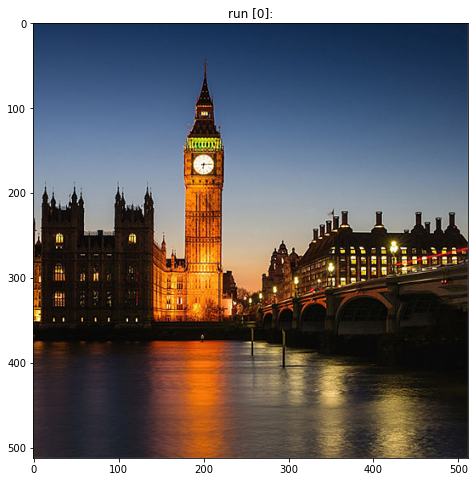

run [50]:
Style Loss : 0.001423 Content Loss: 0.000981 time elapsed: 4.158904075622559 seconds


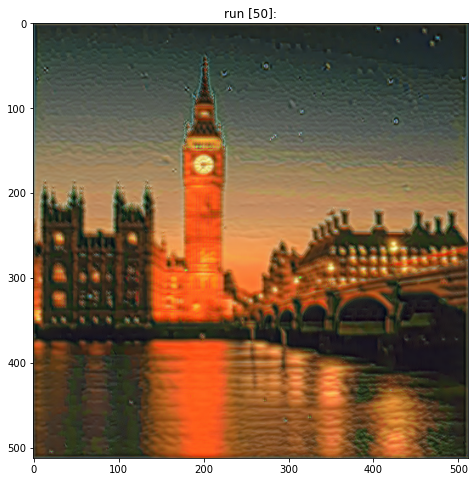

run [100]:
Style Loss : 0.000337 Content Loss: 0.000479 time elapsed: 8.677689552307129 seconds


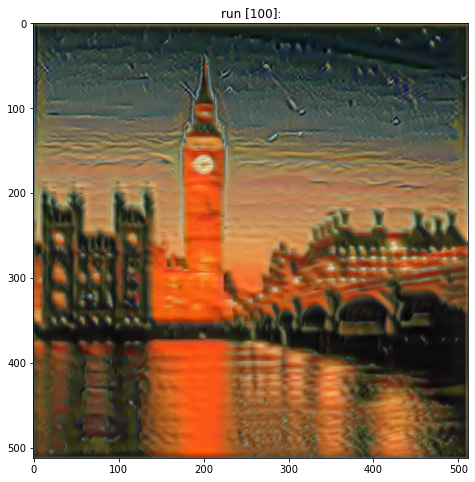

In [9]:
out = style_transfer(
    VGGStyleTransferModel(robust_vgg, datasets.CIFAR().mean, datasets.CIFAR().std), 
    './imgs/notebook-styletransfer-bigben.jpg', './imgs/the_scream.jpg', style_weight=4e6, content_weight=1,
    start_from_content=True, n_iters=[0, 50, 100], content_layers=['conv_10'],
    style_layers = ['conv_1', 'conv_3', 'conv_5', 'conv_9', 'conv_13'], opt='LBFGS')



# Regular VGG (not trained robustly)

run [0]:
Style Loss : 7.553363 Content Loss: 0.000000 time elapsed: 0.12593460083007812 seconds


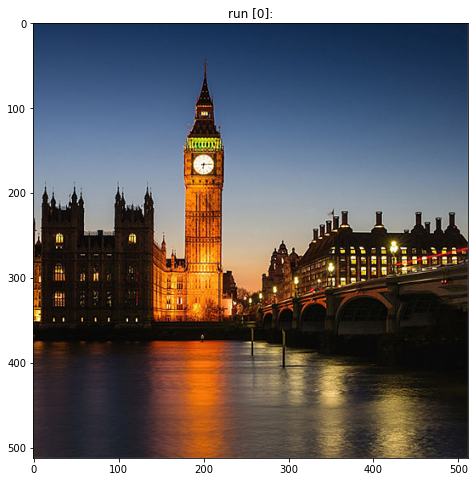

run [50]:
Style Loss : 25.703798 Content Loss: 0.000056 time elapsed: 4.18610692024231 seconds


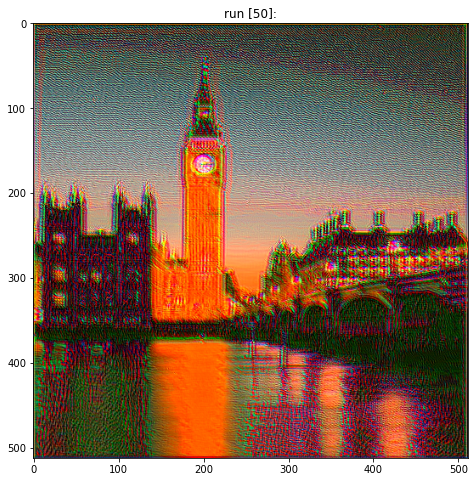

run [100]:
Style Loss : 0.008884 Content Loss: 0.000036 time elapsed: 8.62196159362793 seconds


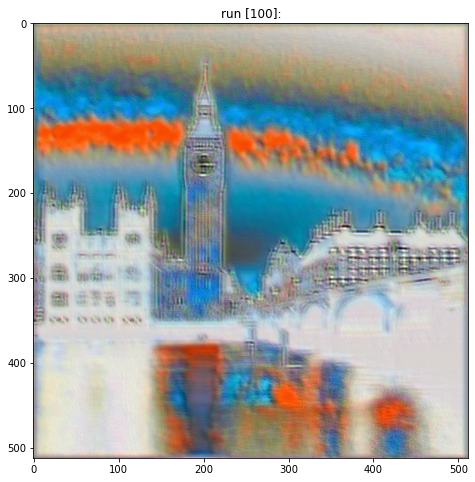

In [10]:
out = style_transfer(
    VGGStyleTransferModel(reg_robust_vgg, datasets.CIFAR().mean, datasets.CIFAR().std), 
    './imgs/notebook-styletransfer-bigben.jpg', './imgs/the_scream.jpg', style_weight=4e6, content_weight=1,
    start_from_content=True, n_iters=[0, 50, 100], content_layers=['conv_10'],
    style_layers = ['conv_1', 'conv_3', 'conv_5', 'conv_9', 'conv_13'], opt='LBFGS')